In [1]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


In [2]:
# Whole network composed of 63 layers, approximately 2.6m total no. of parameters
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D,\
                                    GlobalAvgPool2D, Dense, Add, Concatenate, Input,\
                                    Dropout
from tensorflow.keras import Model

# Note: tf version 2.9.1 does not have Identity layer. Implement our own identity layer which is argument insensitive
# and returns its inputs argument as output

In [14]:
# mpriupperhalf_convno, batch_no, pooling_dropout, output_convno,
# fc_dropout, lr, l2_conv2d
def input_module(x):

    # Set no. of filters to 256 to match the output of Add layer at the end of
    # upper half of MPRI module
    x = Conv2D(filters = 256, kernel_size = 3, strides = 1,
               padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Normally, strides = 2 to reduce dimensions but set strides =1 for now to match
    # output shapes
    x = MaxPool2D(pool_size= 3, strides = 2, padding = 'same')(x)

    return x

def mpri_upperhalf(x):

    # Save input as another variable since need to add input of mpri
    # with output of mpri
    input_tensor = x

    # Bottleneck layer with 1x1 conv filter
    bottlenecked_tensor = Conv2D(filters = 128, kernel_size = 1, strides = 1,
                                 padding = 'same')(x)

    # First path
    firstpath_tensor = BatchNormalization()(bottlenecked_tensor)
    firstpath_tensor = ReLU()(firstpath_tensor)
    firstpath_tensor = Conv2D(filters = 64, kernel_size = 1, strides = 1,
                              padding = 'same')(firstpath_tensor)

    # Second path
    secondpath_tensor = BatchNormalization()(bottlenecked_tensor)
    secondpath_tensor = ReLU()(secondpath_tensor)
    secondpath_tensor = Conv2D(filters = 32, kernel_size = (5,1), strides = 1,
                               padding = 'same')(secondpath_tensor)
    secondpath_tensor = Conv2D(filters = 32, kernel_size = (1,3), strides = 1,
                               padding = 'same')(secondpath_tensor)

    # Third path
    # Normally, strides = 2 to reduce the dimensions of the input
    # In this case, experiment with strides = 1 to fit desired output shape for concatenation layer
    thirdpath_tensor = MaxPool2D(pool_size = 3, strides = 1, padding = 'same')(bottlenecked_tensor)
    thirdpath_tensor = BatchNormalization()(thirdpath_tensor)
    thirdpath_tensor = ReLU()(thirdpath_tensor)
    thirdpath_tensor = Conv2D(filters = 32, kernel_size = 3, strides = 1,
                              padding = 'same')(thirdpath_tensor)

    # Fourth path
    fourthpath_tensor = BatchNormalization()(bottlenecked_tensor)
    fourthpath_tensor = ReLU()(fourthpath_tensor)
    fourthpath_tensor = Conv2D(filters = 32, kernel_size = 1, strides = 1,
                               padding = 'same')(fourthpath_tensor)

    fourthpath_tensor = BatchNormalization()(fourthpath_tensor)
    fourthpath_tensor = ReLU()(fourthpath_tensor)
    fourthpath_tensor = Conv2D(filters = 128, kernel_size = 1, strides = 1,
                               padding = 'same')(fourthpath_tensor)

    # Depth concatenate the output from the four paths
    concatenated_tensor = Concatenate()([firstpath_tensor, secondpath_tensor, thirdpath_tensor, fourthpath_tensor])

    # Add the depth concatenated layer and input tensor
    # To add successfully, input tensor must have 256 channels as well to match the shape of
    # the concatenated tensor
    output_tensor = Add()([input_tensor, concatenated_tensor])

    return output_tensor

def mpri_lowerhalf(x):

    def conv3x3_block(x):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters = 256, kernel_size = 3, strides = 1,
                   padding = 'same')(x)
        return x

    def conv1x1_block(x):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters = 256, kernel_size = 1, strides = 1,
                   padding = 'same')(x)
        return x

    # --- First layer ---
    upperpath_pooledtensor = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
    upperpath_tensor = conv3x3_block(upperpath_pooledtensor)

    lowerpath_pooledtensor = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
    lowerpath_tensor = conv1x1_block(lowerpath_pooledtensor)

    upperpath_tensor = Add()([upperpath_pooledtensor, upperpath_tensor, lowerpath_tensor])
    lowerpath_tensor = Add()([lowerpath_pooledtensor, lowerpath_tensor, upperpath_tensor])

    # --- Second layer ---
    upperpath_pooledtensor = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(upperpath_tensor)
    upperpath_tensor = conv3x3_block(upperpath_pooledtensor)

    lowerpath_pooledtensor = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(lowerpath_tensor)
    lowerpath_tensor = conv1x1_block(lowerpath_pooledtensor)

    upperpath_tensor = Add()([upperpath_pooledtensor, upperpath_tensor, lowerpath_tensor])
    lowerpath_tensor = Add()([lowerpath_pooledtensor, lowerpath_tensor, upperpath_tensor])

    # --- Third layer ---
    upperpath_pooledtensor = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(upperpath_tensor)
    upperpath_tensor = conv3x3_block(upperpath_pooledtensor)

    lowerpath_pooledtensor = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(lowerpath_tensor)
    lowerpath_tensor = conv1x1_block(lowerpath_pooledtensor)

    upperpath_tensor = Add()([upperpath_pooledtensor, upperpath_tensor, lowerpath_tensor])
    lowerpath_tensor = Add()([lowerpath_pooledtensor, lowerpath_tensor, upperpath_tensor])

    # Final layer - Add upper and lower path tensors
    output_tensor = Add()([upperpath_tensor, lowerpath_tensor])

    return output_tensor

def output_module(x, num_classes = 1000):

    x = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dropout(rate = 0.5)(x)
    x = Dense(units = num_classes, activation = 'softmax')(x)

    return x

In [6]:
print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/mpri
/home/jovyan/committed_git/datasets


In [7]:
import h5py

# Get dictionary of RP index and coordinates
# Open HDF5 file and access the dataset
filename = 'dataset_SNR10_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

# Close the HDF5 file
hdf5_file.close()

In [8]:
# Import dataset

features = np.load('augmented_features_10_ue1_v2_ds.npy')
labels = np.load('augmented_labels_10_ue1_v2_ds.npy')

print(f'Shape of features np array: {features.shape}')
print(f'Shape of labels np array: {labels.shape}')

Shape of features np array: (89628, 193, 16)
Shape of labels np array: (89628,)


In [9]:
from sklearn.model_selection import train_test_split

X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [10]:
print(os.getcwd())
os.chdir('../mpri')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/mpri


In [29]:
# Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val, cur_val_loss, val_loss_threshold):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        self.cur_val_loss = cur_val_loss
        self.val_loss_threshold = val_loss_threshold
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print('\n')
        print('Epoch End - Custom Validation Callback')
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)
        
        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
        rmse = np.sqrt((err_sum/len(self.X_val)))
       
        # Save values to log
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse
        
        # Whenever validation loss is minimised and below threshold, save the model
        # and update current minimum loss
        if val_loss < self.cur_val_loss and val_loss < self.val_loss_threshold:
            self.model.save('mpri_model.h5')
            self.cur_val_loss = val_loss

In [30]:
# Same as above, but removed early stopping callback
from sklearn.model_selection import train_test_split
from tensorflow import keras
import math
import time

class MPRI_model:
    
    def __init__(self):
        
        model_input = Input(shape = (193,16,1))
        model_output = output_module(mpri_lowerhalf(mpri_upperhalf(input_module(model_input))), num_classes = 3876)
        self.model = Model(model_input, model_output)

        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
        self.model.compile(optimizer = optimizer,
                      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics = ['accuracy'])

        self.model.summary()
        
    def train_model(self):
    
        # In training, use model.fit() validation callback to get results on training loss, training accuracy,
        # validation loss and validation accuracy and rmse after every epoch
        val_callback = ValidationCallback(X_test, y_test, math.inf, 1)
        
        # Can leave out early stopping for now, manually observe when val_loss stops improving to determine
        # optimal number of epochs
        
        # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        start_time = time.time()
        hist = self.model.fit(X_train, y_train,
                              epochs = 100,
                              batch_size = 64,
                              callbacks = [val_callback]
#                              callbacks = [val_callback, stop_early]
                             )
        
        end_time = time.time()
        print(f'Time taken to clear 100 epochs: {end_time - start_time}')
        
        return hist
    
    def calc_error(self, actual, predicted):

            x_error = (actual[0] - predicted[0])**2
            y_error = (actual[1] - predicted[1])**2
            z_error = (actual[2] - predicted[2])**2

            return x_error + y_error + z_error
    
    def calc_errorcdf(self, errors):
        
        # Sort the array
        sorted_data = np.sort(errors)

        # Calculate cumulative probabilities
        n = len(sorted_data)
        cumulative_probs = np.arange(1, n + 1) / n
    
        return (sorted_data, cumulative_probs)
        
    def test_model(self, filename):
        
        # Load model
        self.model = keras.models.load_model(filename)
        
        # In test, use model.predict() to get the RMSE errors of predictions and CDF of distance error
        y_pred = self.model.predict(X_test, verbose = 0)
        err_sum = 0
        
        dist_errors = []
        max_disterror = -math.inf
        max_disterror_actual, max_disterror_pred = None, None
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(X_test)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[y_test[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            
            # Update the maximum errror, if needed
            dist_err = np.sqrt(err)
            if dist_err > max_disterror:
                
                # Update max error
                max_disterror = dist_err
                
                # Return the class index and then retrieve actual coordinates from rp_dict
                max_disterror_actual = y_test[i]
                max_disterror_pred = predicted_rp
            
            # Append error to distance errors
            dist_errors.append(dist_err)
            err_sum += err
            
        # Get RMSE of all predicted points
        rmse = np.sqrt((err_sum/len(X_test)))
        
        # Get actual and predicted point with the largest error
        print(f'Largest error: {max_disterror}, Actual RP index: {max_disterror_actual}, Predicted RP index: {max_disterror_pred}')
        
        return (rmse, *self.calc_errorcdf(dist_errors))

In [31]:
# Train model
mpri_model = MPRI_model()
trg_results = mpri_model.train_model()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 193, 16, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_75 (Conv2D)             (None, 193, 16, 256  2560        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_65 (BatchN  (None, 193, 16, 256  1024       ['conv2d_75[0][0]']              
 ormalization)                  )                                                           

In [32]:
loss = trg_results.history['loss']
acc = trg_results.history['accuracy']
val_loss = trg_results.history['val_loss']
val_acc = trg_results.history['val_accuracy']
rmse = trg_results.history['rmse']
epochs = [i for i in range(len(rmse))]

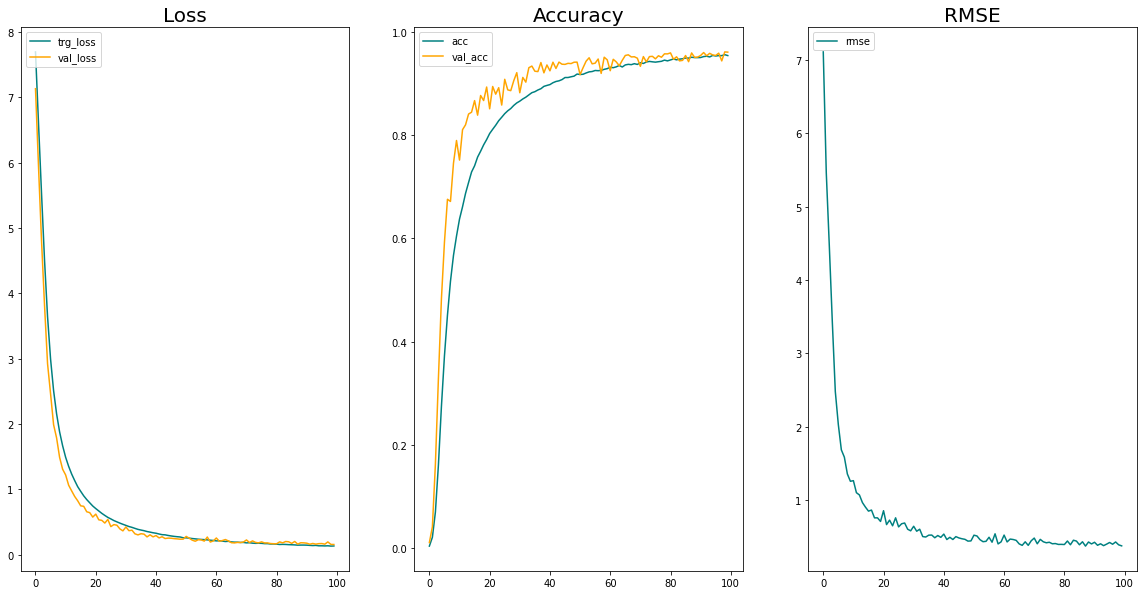

In [33]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(1,3)

axs[0].plot(epochs, loss, color='teal', label='trg_loss')
axs[0].plot(epochs, val_loss, color='orange', label='val_loss')
axs[0].legend(loc='upper left')
axs[0].set_title('Loss', fontsize=20)

axs[1].plot(epochs, acc, color='teal', label='acc')
axs[1].plot(epochs, val_acc, color='orange', label='val_acc')
axs[1].legend(loc='upper left')
axs[1].set_title('Accuracy', fontsize=20)

axs[2].plot(epochs, rmse, color='teal', label='rmse')
axs[2].legend(loc='upper left')
axs[2].set_title('RMSE', fontsize=20)

plt.show()

In [34]:
val_loss = np.array(val_loss)
print(f'Minimum loss: {val_loss.min()}')
best_epoch = np.where(val_loss == val_loss.min())[0][0]

print(f'Best Epoch no: {best_epoch}')
print(f'Best val loss: {val_loss[best_epoch]}, Best val acc: {val_acc[best_epoch]}')
print(f'Best trg loss: {loss[best_epoch]}, Best trg acc: {acc[best_epoch]}')

Minimum loss: 0.15366923809051514
Best Epoch no: 99
Best val loss: 0.15366923809051514, Best val acc: 0.961675763130188
Best trg loss: 0.1310051530599594, Best trg acc: 0.9550082087516785


In [35]:
# Test model
rmse, dist_errors, cdf_vals = mpri_model.test_model("mpri_model.h5")

Largest error: 8.139410298049853, Actual RP index: 1868, Predicted RP index: 1750


In [36]:
print(rmse)

0.37467677319133735


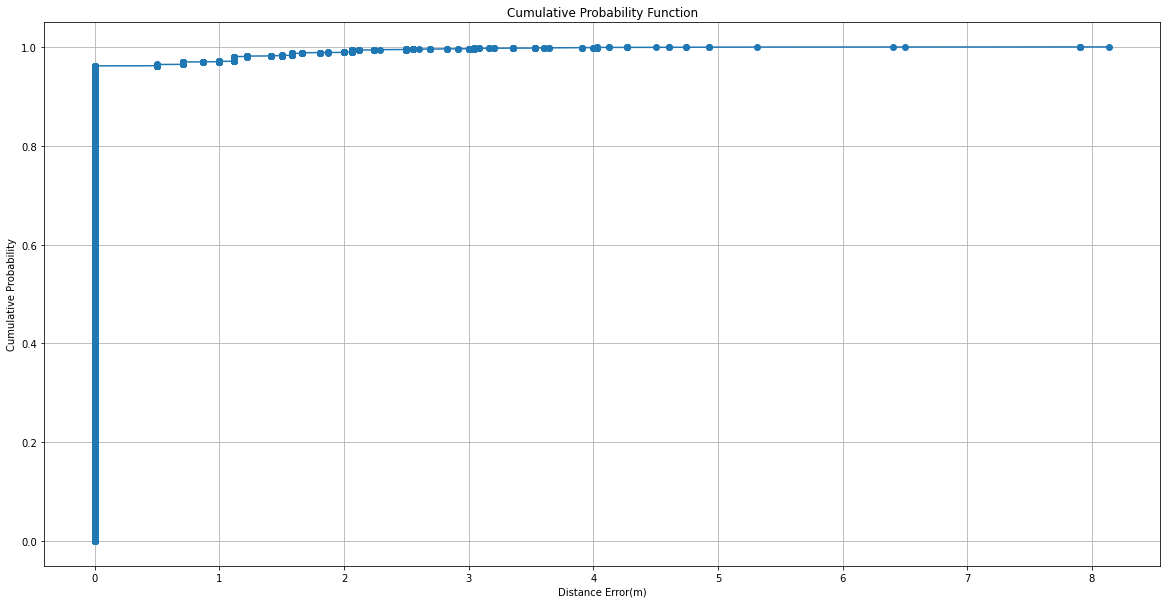

In [37]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(dist_errors, cdf_vals, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()

## Repeat but with 400 epochs

In [3]:
# Whole network composed of 63 layers, approximately 2.6m total no. of parameters
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D,\
                                    GlobalAvgPool2D, Dense, Add, Concatenate, Input,\
                                    Dropout
from tensorflow.keras import Model

# Note: tf version 2.9.1 does not have Identity layer. Implement our own identity layer which is argument insensitive
# and returns its inputs argument as output

In [11]:
# Create custom callbacks to evaluate model
class ValidationCallback2(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val, cur_val_loss, val_loss_threshold):
        super(ValidationCallback2,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        self.cur_val_loss = cur_val_loss
        self.val_loss_threshold = val_loss_threshold
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print('\n')
        print('Epoch End - Custom Validation Callback')
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)
        
        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
        rmse = np.sqrt((err_sum/len(self.X_val)))
       
        # Save values to log
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse
        
        # Whenever validation loss is minimised and below threshold, save the model
        # and update current minimum loss
        if val_loss < self.cur_val_loss and val_loss < self.val_loss_threshold:
            self.model.save('mpri_model2.h5')
            self.cur_val_loss = val_loss

In [15]:
# Same as above, but removed early stopping callback
from sklearn.model_selection import train_test_split
from tensorflow import keras
import math
import time

class MPRI_model2:
    
    def __init__(self):
        
        model_input = Input(shape = (193,16,1))
        model_output = output_module(mpri_lowerhalf(mpri_upperhalf(input_module(model_input))), num_classes = 3876)
        self.model = Model(model_input, model_output)

        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
        self.model.compile(optimizer = optimizer,
                      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics = ['accuracy'])

        self.model.summary()
        
    def train_model(self):
    
        # In training, use model.fit() validation callback to get results on training loss, training accuracy,
        # validation loss and validation accuracy and rmse after every epoch
        val_callback = ValidationCallback2(X_test, y_test, math.inf, 1)
        
        # Can leave out early stopping for now, manually observe when val_loss stops improving to determine
        # optimal number of epochs
        
        # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        start_time = time.time()
        hist = self.model.fit(X_train, y_train,
                              epochs = 400,
                              batch_size = 64,
                              callbacks = [val_callback]
#                              callbacks = [val_callback, stop_early]
                             )
        
        end_time = time.time()
        print(f'Time taken to clear 400 epochs: {end_time - start_time}')
        
        return hist
    
    def calc_error(self, actual, predicted):

            x_error = (actual[0] - predicted[0])**2
            y_error = (actual[1] - predicted[1])**2
            z_error = (actual[2] - predicted[2])**2

            return x_error + y_error + z_error
    
    def calc_errorcdf(self, errors):
        
        # Sort the array
        sorted_data = np.sort(errors)

        # Calculate cumulative probabilities
        n = len(sorted_data)
        cumulative_probs = np.arange(1, n + 1) / n
    
        return (sorted_data, cumulative_probs)
        
    def test_model(self, filename):
        
        # Load model
        self.model = keras.models.load_model(filename)
        
        # In test, use model.predict() to get the RMSE errors of predictions and CDF of distance error
        y_pred = self.model.predict(X_test, verbose = 0)
        err_sum = 0
        
        dist_errors = []
        max_disterror = -math.inf
        max_disterror_actual, max_disterror_pred = None, None
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(X_test)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[y_test[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            
            # Update the maximum errror, if needed
            dist_err = np.sqrt(err)
            if dist_err > max_disterror:
                
                # Update max error
                max_disterror = dist_err
                
                # Return the class index and then retrieve actual coordinates from rp_dict
                max_disterror_actual = y_test[i]
                max_disterror_pred = predicted_rp
            
            # Append error to distance errors
            dist_errors.append(dist_err)
            err_sum += err
            
        # Get RMSE of all predicted points
        rmse = np.sqrt((err_sum/len(X_test)))
        
        # Get actual and predicted point with the largest error
        print(f'Largest error: {max_disterror}, Actual RP index: {max_disterror_actual}, Predicted RP index: {max_disterror_pred}')
        
        return (rmse, *self.calc_errorcdf(dist_errors))

In [ ]:
# Train model
mpri_model2 = MPRI_model2()
trg_results2 = mpri_model2.train_model()

2023-06-23 05:13:31.420720: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 05:13:31.869698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25091 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 193, 16, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 193, 16, 256  2560        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 193, 16, 256  1024       ['conv2d[0][0]']                 
 alization)                     )                                                             

2023-06-23 05:13:35.132909: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-06-23 05:13:36.426460: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1121/1121 [==============================] - ETA: 0s - loss: 7.7098 - accuracy: 0.0030

Epoch End - Custom Validation Callback
1121/1121 [==============================] - 43s 35ms/step - loss: 7.7098 - accuracy: 0.0030 - val_loss: 7.1098 - val_accuracy: 0.0112 - rmse: 7.0570
Epoch 2/400
1121/1121 [==============================] - ETA: 0s - loss: 6.6023 - accuracy: 0.0227

Epoch End - Custom Validation Callback
1121/1121 [==============================] - 39s 35ms/step - loss: 6.6023 - accuracy: 0.0227 - val_loss: 5.8694 - val_accuracy: 0.0534 - rmse: 5.4190
Epoch 3/400
1119/1121 [============================>.] - ETA: 0s - loss: 5.4616 - accuracy: 0.0771

Epoch End - Custom Validation Callback
1121/1121 [==============================] - 39s 34ms/step - loss: 5.4610 - accuracy: 0.0771 - val_loss: 4.7461 - val_accuracy: 0.1844 - rmse: 4.0368
Epoch 4/400
1119/1121 [============================>.] - ETA: 0s - loss: 4.4058 - accuracy: 0.1800

Epoch End - Custom Validation Callback
1121/1

In [1]:
loss2 = trg_results2.history['loss']
acc2 = trg_results2.history['accuracy']
val_loss2 = trg_results2.history['val_loss']
val_acc2 = trg_results2.history['val_accuracy']
rmse2 = trg_results2.history['rmse']
epochs2 = [i for i in range(len(rmse2))]

NameError: name 'trg_results2' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(1,3)

axs[0].plot(epochs2, loss2, color='teal', label='trg_loss')
axs[0].plot(epochs2, val_loss2, color='orange', label='val_loss')
axs[0].legend(loc='upper left')
axs[0].set_title('Loss', fontsize=20)

axs[1].plot(epochs2, acc2, color='teal', label='acc')
axs[1].plot(epochs2, val_acc2, color='orange', label='val_acc')
axs[1].legend(loc='upper left')
axs[1].set_title('Accuracy', fontsize=20)

axs[2].plot(epochs2, rmse2, color='teal', label='rmse')
axs[2].legend(loc='upper left')
axs[2].set_title('RMSE', fontsize=20)

plt.show()

In [ ]:
val_loss2= np.array(val_loss2
print(f'Minimum loss: {val_loss2min()}')
best_epoch2= np.where(val_loss2== val_loss2min())[0][0]

print(f'Best Epoch no: {best_epoch2}')
print(f'Best val loss: {val_loss2best_epoch2}, Best val acc: {val_acc2best_epoch2}')
print(f'Best trg loss: {loss2best_epoch2}, Best trg acc: {acc2best_epoch2}')

In [ ]:
# Test model
rmse2, dist_errors2, cdf_vals2 = mpri_model2.test_model("mpri_model2.h5")

In [ ]:
print(rmse2)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(dist_errors2, cdf_vals2, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()